In [1]:
# Import libraries
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import skgstat as skg
import gstools as gs

import matplotlib.pyplot as plt

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\skgstat\models.py:23: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def spherical(h, r, c0, b=0):
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\skgstat\models.py:87: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def exponential(h, r, c0, b=0):
C:\Users

In [2]:
# Specify filepaths and filenames.
filepath = 'Data/'
filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Make column with year from current year max date
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

print(data.shape)

(4171, 302)


C:\Users\kasj\AppData\Local\Temp\ipykernel_14552\3726511938.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [10]:
# Clean point where winter mass balance = 9.99
data[data['balance_winter']==9.99]
data = data[data['balance_winter'] != 9.99].reset_index(drop=True)

In [11]:
print(data.shape)

(4170, 302)


## Get stats for dataset

In [12]:
# Get stats
# Stats for quality of approximate locations and altitudes:
mean_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].mean()
min_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].min()
max_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].max()
sd_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].std()

mean_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].mean()
min_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].min()
max_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].max()
sd_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].std()

mean_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].mean()
min_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].min()
max_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].max()
sd_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].std()

# Number of instances of winter balance: 3680
no_winter = data['balance_winter'].notna().sum()

# Number of instances of summer balance: 3805
no_summer = data['balance_summer'].notna().sum()

# Number of instances of annual balance: 3839
no_annual = data['balance_netto'].notna().sum()

# Number of points with exact coordinates: 3717 of 4046
no_exact_locs = (data['approx_loc'].values == 'N').sum()

# Number of points with approximate coordinates: 329 of 4046
no_approx_locs = (data['approx_loc'].values == 'Y').sum()
    
# Number of points with exact altitude: 4009
no_exact_alt = (data['approx_altitude'].values == 'N').sum()

# Number of points with exact altitude: 37
no_approx_alt = (data['approx_altitude'].values == 'Y').sum()

# Number of points w/o exact coordinates or altitude: 32
no_approx_both = ((data['approx_altitude'].values == 'Y') & (data['approx_loc'].values == 'Y')).sum()
   
# Number of unique glacier IDs: 32
no_unique_id = data['BREID'].nunique()    

# List of unique glacier IDs:
list_unique_id = list(data['BREID'].unique())

# Unique glacier IDs with number of entries per ID.
# Index is glacier ID and column is number of entries per glacier ID.
len_rec_per_id = data['BREID'].value_counts().to_frame()    

In [16]:
data['altitude'].min()

190.0

In [19]:
# Summary
print('Total number of points: ' + str(data.shape[0]))
print('Number of unique ids: ' + str(no_unique_id))
print('Number of annual mass balance: ' + str(no_annual))
print('Number of winter mass balance: ' + str(no_winter))
print('Number of summer mass balance: ' + str(no_summer))
print('Lowest altitude: ' + str(int(data['altitude'].min())))
print('Highest altitude: ' + str(int(data['altitude'].max())))

Total number of points: 4170
Number of unique ids: 32
Number of annual mass balance: 3910
Number of winter mass balance: 3751
Number of summer mass balance: 3929
Lowest altitude: 190
Highest altitude: 2212


<Figure size 640x480 with 0 Axes>

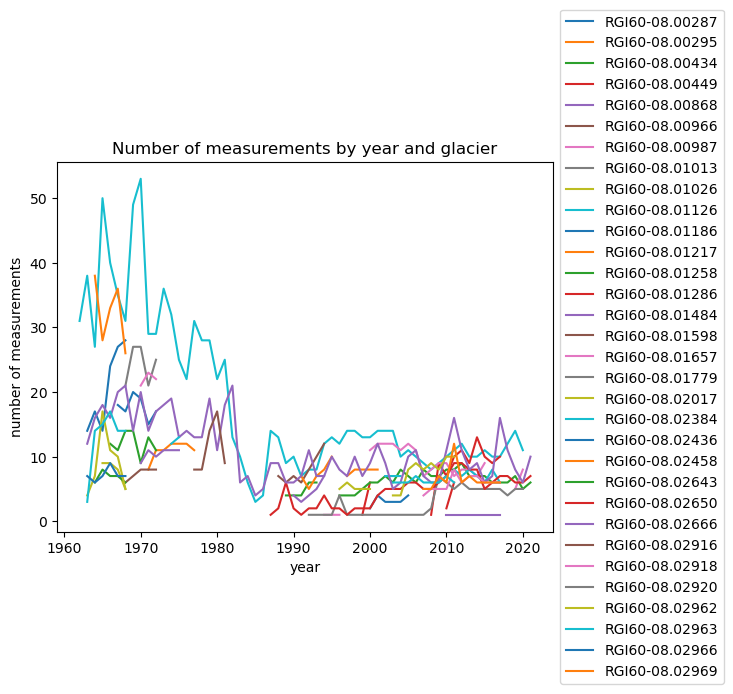

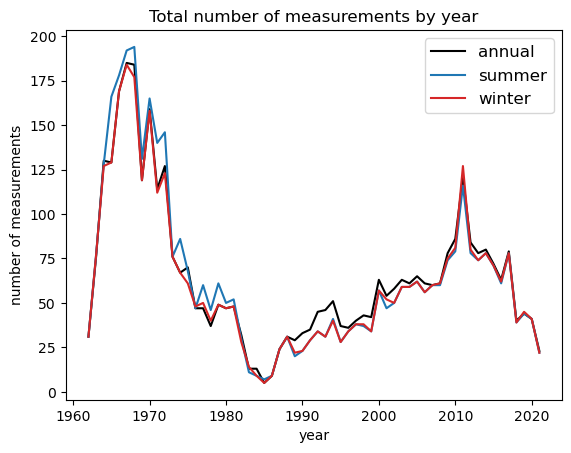

In [5]:
# Plot number of measurements by year, RGIID and type of measurement

# Plot number of measurements per glacier
plt.figure()
data.groupby(['year', "RGIID"]).size().unstack().plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Number of measurements by year and glacier')
plt.ylabel('number of measurements')
plt.show()

data_netto = data[~data['balance_netto'].isnull()]
data_summer = data[~data['balance_summer'].isnull()]
data_winter = data[~data['balance_winter'].isnull()]

# Plot number of measurements per type of measurement
plt.figure()
data_netto.groupby(['year']).size().plot(color='k', legend='annual')
data_summer.groupby(['year']).size().plot(color='C0', legend='summer')
data_winter.groupby(['year']).size().plot(color='C3', legend='winter')
plt.title('Total number of measurements by year')
plt.ylabel('number of measurements')
plt.legend(['annual', 'summer', 'winter'], prop={'size': 12})
plt.show()

# TO-DO: Plot CUMULATIVE number of measurements per type of measurement

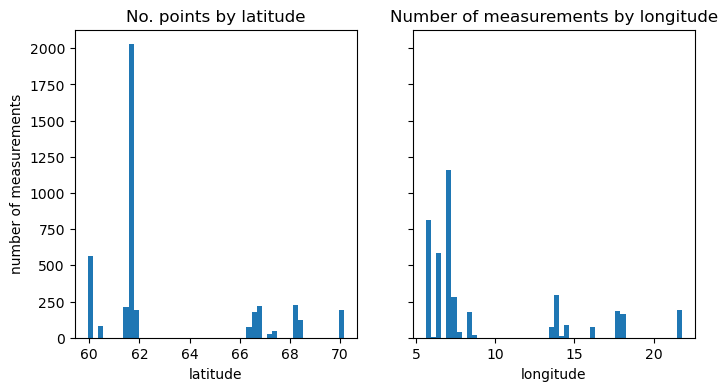

In [6]:
# Plot number of measurements by geographical location

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
data['lat'].plot.hist(bins=50, ax=ax1)
ax1.set_title('No. points by latitude')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('latitude')
data['lon'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Number of measurements by longitude')
ax2.set_ylabel('number of measurements')
ax2.set_xlabel('longitude')

# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

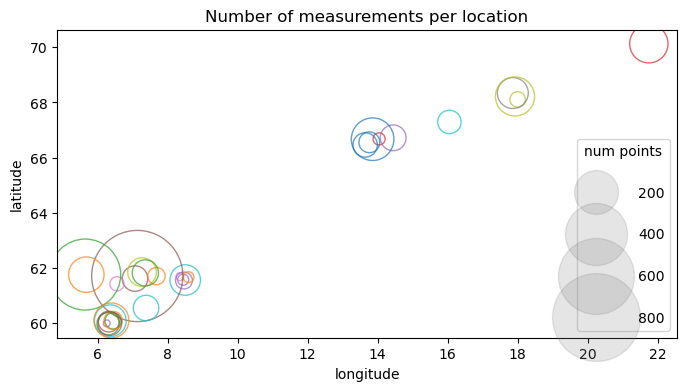

In [7]:
# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

plt.figure(figsize=(8,4))
#labels = list(data['RGIID'].unique())
sc=plt.scatter(x=data.groupby(["RGIID"])['lon'].mean().values, 
               y=data.groupby(["RGIID"])['lat'].mean().values, 
               s=data.groupby(["RGIID"]).size().values*4,
               facecolors='None', edgecolors=c, lw=1, alpha=0.7)#alpha=0.5)#, markerfacecolor="None");#* 200);
#data_netto['lat'].plot.hist(bins=50)
handles, labels = sc.legend_elements(prop="sizes", alpha=0.2, num=5, color='grey')#, fill=None)     
labels = ["200", "400", "600", "800"]     
legend = plt.legend(handles, labels, loc="lower right", title="num points",labelspacing=2, handletextpad=2)
#plt.legend(*sc.legend_elements("sizes", num=6))
plt.title('Number of measurements per location')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

In [128]:
1028/3929

0.2616441842708068

Text(0.5, 0, 'slope (radians? 0.5rad = 28.7deg)')

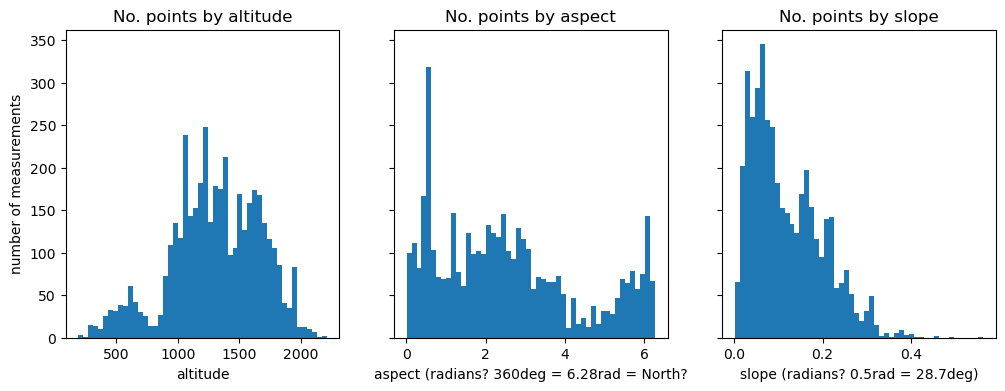

In [8]:
# Number of measurements by topography

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)
data['altitude'].plot.hist(bins=50, ax=ax1)
ax1.set_title('No. points by altitude')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('altitude')

data['aspect'].plot.hist(bins=50, ax=ax2)
ax2.set_title('No. points by aspect')
ax2.set_xlabel('aspect (radians? 360deg = 6.28rad = North?')

data['slope'].plot.hist(bins=50, ax=ax3)
ax3.set_title('No. points by slope')
ax3.set_xlabel('slope (radians? 0.5rad = 28.7deg)')

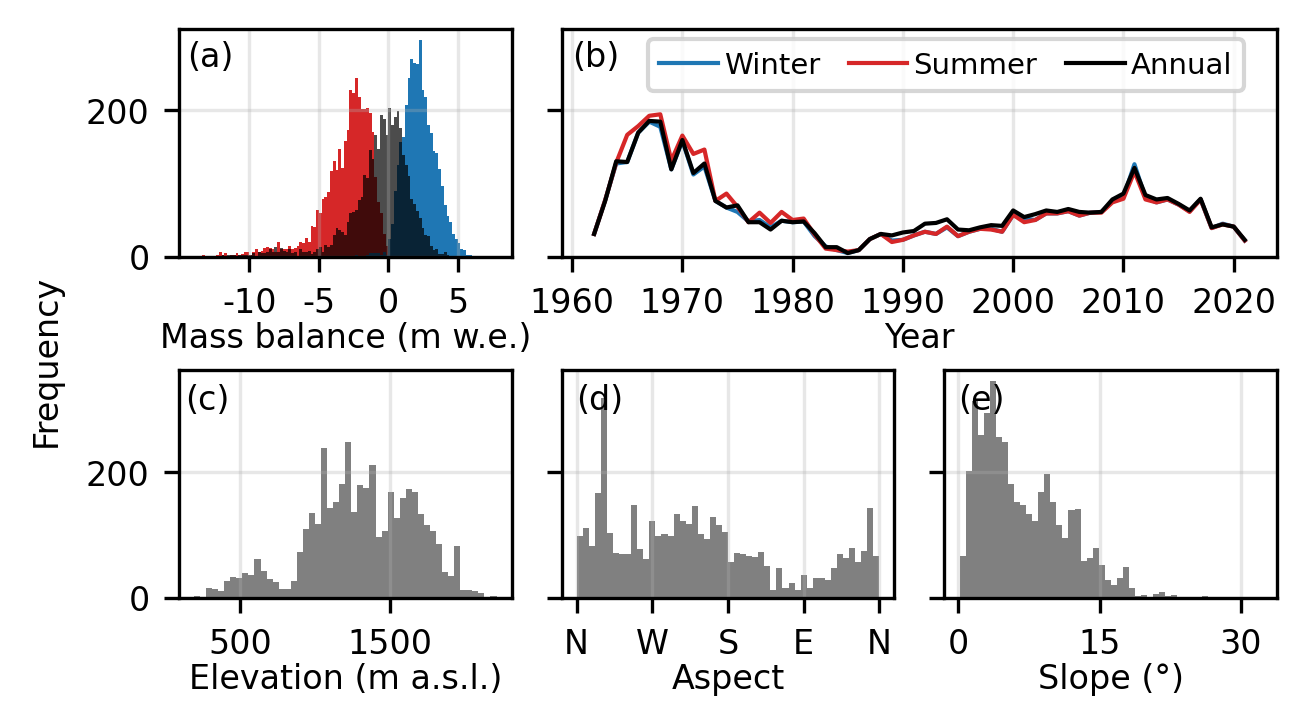

In [118]:
# Number of measurements by topography
data_netto = data[~data['balance_netto'].isnull()]
data_winter = data[~data['balance_winter'].isnull()]
data_summer = data[~data['balance_summer'].isnull()]

cm = 1/2.54
textsize_labels = 8
textsize_ticks = 8

fig = plt.figure(figsize=(12*cm,10*cm), dpi=300)

gs = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,-2:], sharey=ax1)
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1], sharey=ax3)
ax5 = fig.add_subplot(gs[1,2], sharey=ax3)

data['aspect_deg'] = data['aspect']*(180/3.14)
data['slope_deg'] = data['slope']*(180/3.14)

my_bins = np.arange(-14,8,0.2)
#ax1.grid()
#data['balance_summer'].plot.hist(bins=50, ax=ax1, color='C3')
ax1.hist(data['balance_summer'], bins=my_bins,color='C3')#, histtype='stepfille')
#data['balance_winter'].plot.hist(bins=50, ax=ax1, color='C0')
ax1.hist(data['balance_winter'], bins=my_bins,color='C0')#, histtype='step')
#data['balance_netto'].plot.hist(bins=50, ax=ax1, color='k', alpha=0.5)
ax1.hist(data['balance_netto'], bins=my_bins,color='k', alpha=0.7)#, histtype='step')
data_winter.groupby(['year']).size().plot(color='C0', ax=ax2, linewidth=1)#, legend='Winter')#, ax=ax2)
data_summer.groupby(['year']).size().plot(color='C3', ax=ax2, linewidth=1)#, legend='Summer')#, ax=ax2)
data_netto.groupby(['year']).size().plot(color='k', ax=ax2, linewidth=1)#, legend='Annual')#, ax=ax2)
data['altitude'].plot.hist(bins=50, ax=ax3, color='grey')
data['aspect_deg'].plot.hist(bins=50, ax=ax4, color='grey')
data['slope_deg'].plot.hist(bins=50, ax=ax5, color='grey')

ax1.set_xticks([-10,-5,0,5], labels=[-10,-5,0,5], fontsize=textsize_ticks)
ax2.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax3.set_xticks([500,1500], labels=[500,1500], fontsize=textsize_ticks)
ax4.tick_params(axis='both', which='major', labelsize=textsize_ticks)
#ax5.set_xticks([0.0,0.2,0.4,0.6], labels=[0.0,0.02,0.04,0.06], fontsize=textsize_ticks)
ax4.set_xticks([0,90,180,270,360], labels=['N','W','S','E','N'], fontsize=textsize_ticks)
ax5.set_xticks([0,15,30], labels=[0,15,30], fontsize=textsize_ticks)

ax1.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax3.tick_params(axis='both', which='major', labelsize=textsize_ticks)
ax2.legend(['Winter','Summer','Annual'],loc = 'upper left', fontsize=7, labelspacing=0.2, bbox_to_anchor=(0.1,1.02), ncols=3, columnspacing=1, handletextpad=0.2)

ax1.set_ylabel('')
ax3.set_ylabel('')
fig.supylabel('Frequency', fontsize=textsize_labels, y=0.6)
ax1.set_xlabel('Mass balance (m w.e.)', fontsize=textsize_labels, labelpad=0.5)
ax2.set_xlabel('Year', fontsize=textsize_labels, labelpad=0.5)
ax3.set_xlabel('Elevation (m a.s.l.)', fontsize=textsize_labels, labelpad=0.5)
ax4.set_xlabel('Aspect', fontsize=textsize_labels, labelpad=0.5)# (radians? 360deg = 6.28rad = North?')
ax5.set_xlabel('Slope (°)', fontsize=textsize_labels, labelpad=0.5)# (radians? 0.5rad = 28.7deg)')
ax1.grid(alpha=0.3, zorder=0)
ax2.grid(alpha=0.3, zorder=0)
ax3.grid(alpha=0.3, zorder=0)
ax4.grid(alpha=0.3, zorder=0)
ax5.grid(alpha=0.3, zorder=0)

ax1.annotate('(a)', xy=(-14.5,260), fontsize=textsize_ticks, zorder=3)
ax2.annotate('(b)', xy=(1960,260), fontsize=textsize_ticks, zorder=3)
ax3.annotate('(c)', xy=(130,300), fontsize=textsize_ticks, zorder=3)
ax4.annotate('(d)', xy=(-0.2,300), fontsize=textsize_ticks, zorder=3)
ax5.annotate('(e)', xy=(-0.01,300), fontsize=textsize_ticks, zorder=3)

plt.subplots_adjust(hspace=0.5, wspace=0.15)

pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
plt.savefig(pdf_path+'dataset_stats.pdf', format='pdf', bbox_inches='tight')



Text(0.5, 0, 'winter mass balance')

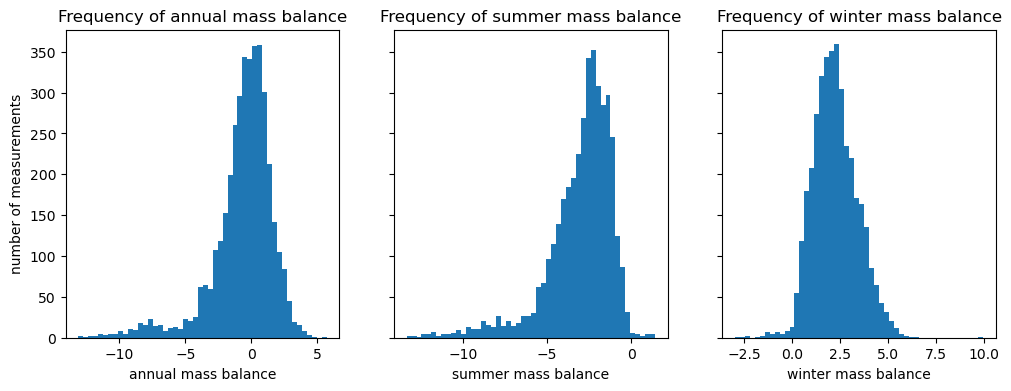

In [10]:
# Number of measurements by mass balance

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True)
data['balance_netto'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Frequency of annual mass balance')
ax1.set_ylabel('number of measurements')
ax1.set_xlabel('annual mass balance')

data['balance_summer'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Frequency of summer mass balance')
ax2.set_xlabel('summer mass balance')

data['balance_winter'].plot.hist(bins=50, ax=ax3)
ax3.set_title('Frequency of winter mass balance')
ax3.set_xlabel('winter mass balance')

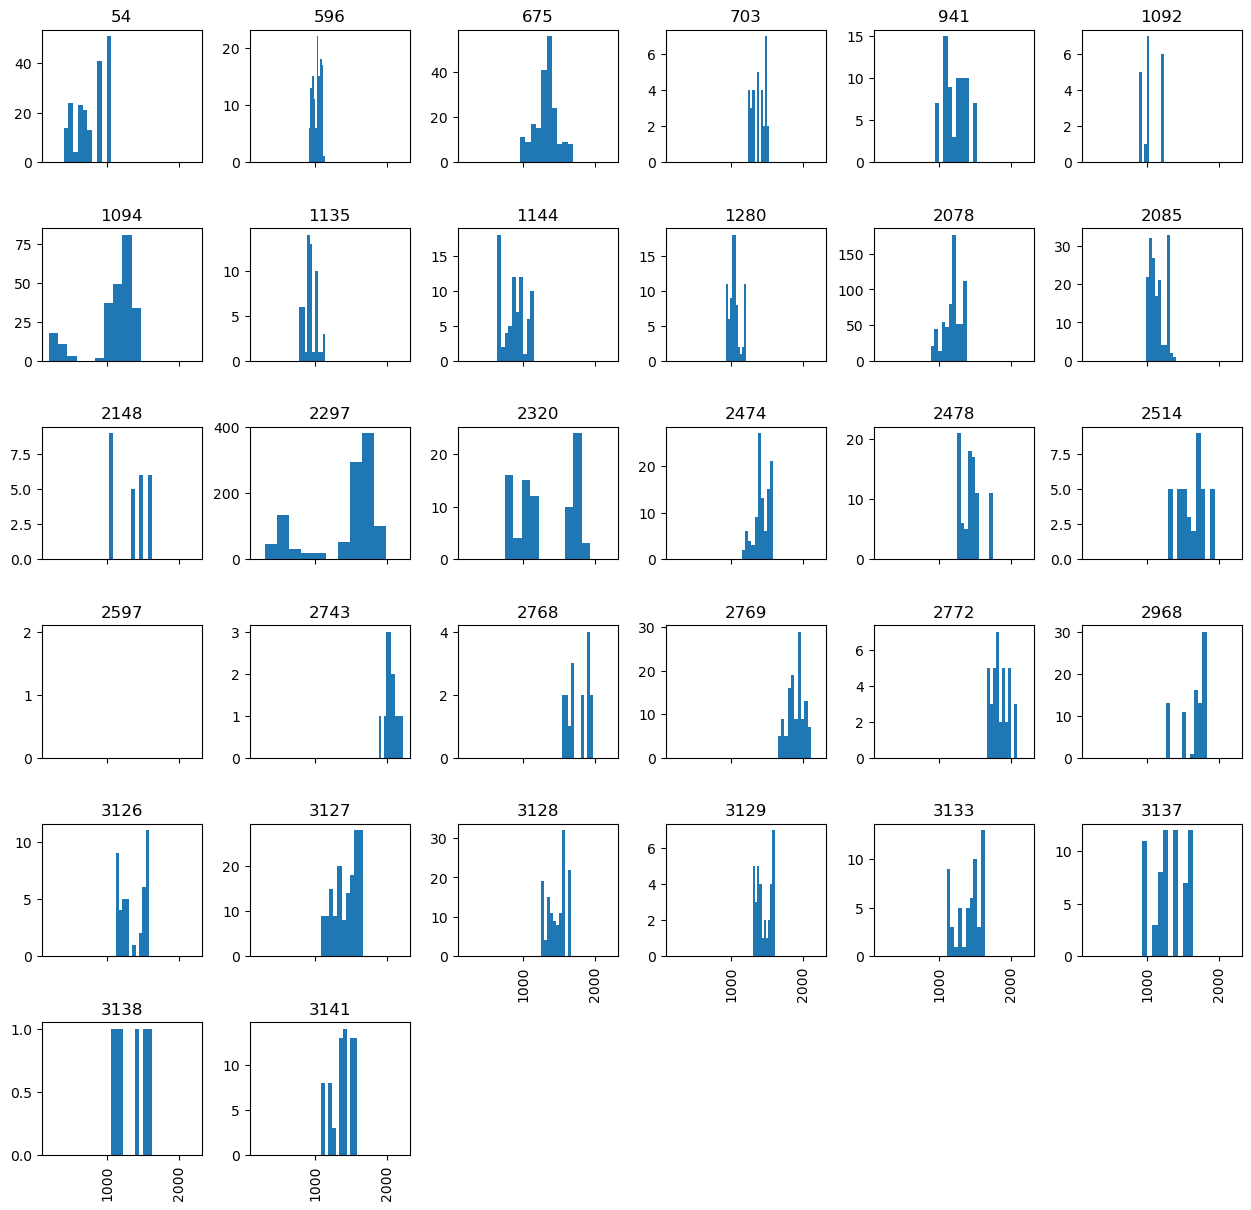

In [11]:
# Plot altitude distribution per glacier
data['altitude'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

In [12]:
data.loc[data['BREID']==2597, ['balance_netto','altitude']]


,balance_netto,altitude
3325,-3.70,1886.0
3326,-1.88,1885.0
3327,0.07,1884.0
3328,-1.55,1882.0
3329,-2.30,1882.0
3330,0.57,1880.0
3331,-1.20,1884.0
3332,0.25,1883.0


### Mass balance per glacier

Only two glaciers have mass balance values in the order of -10 m w.e: 1094 (Engabreen, high latitude, low elevation) and 2297 (Nigardsbreen, low latitude, low elevation)

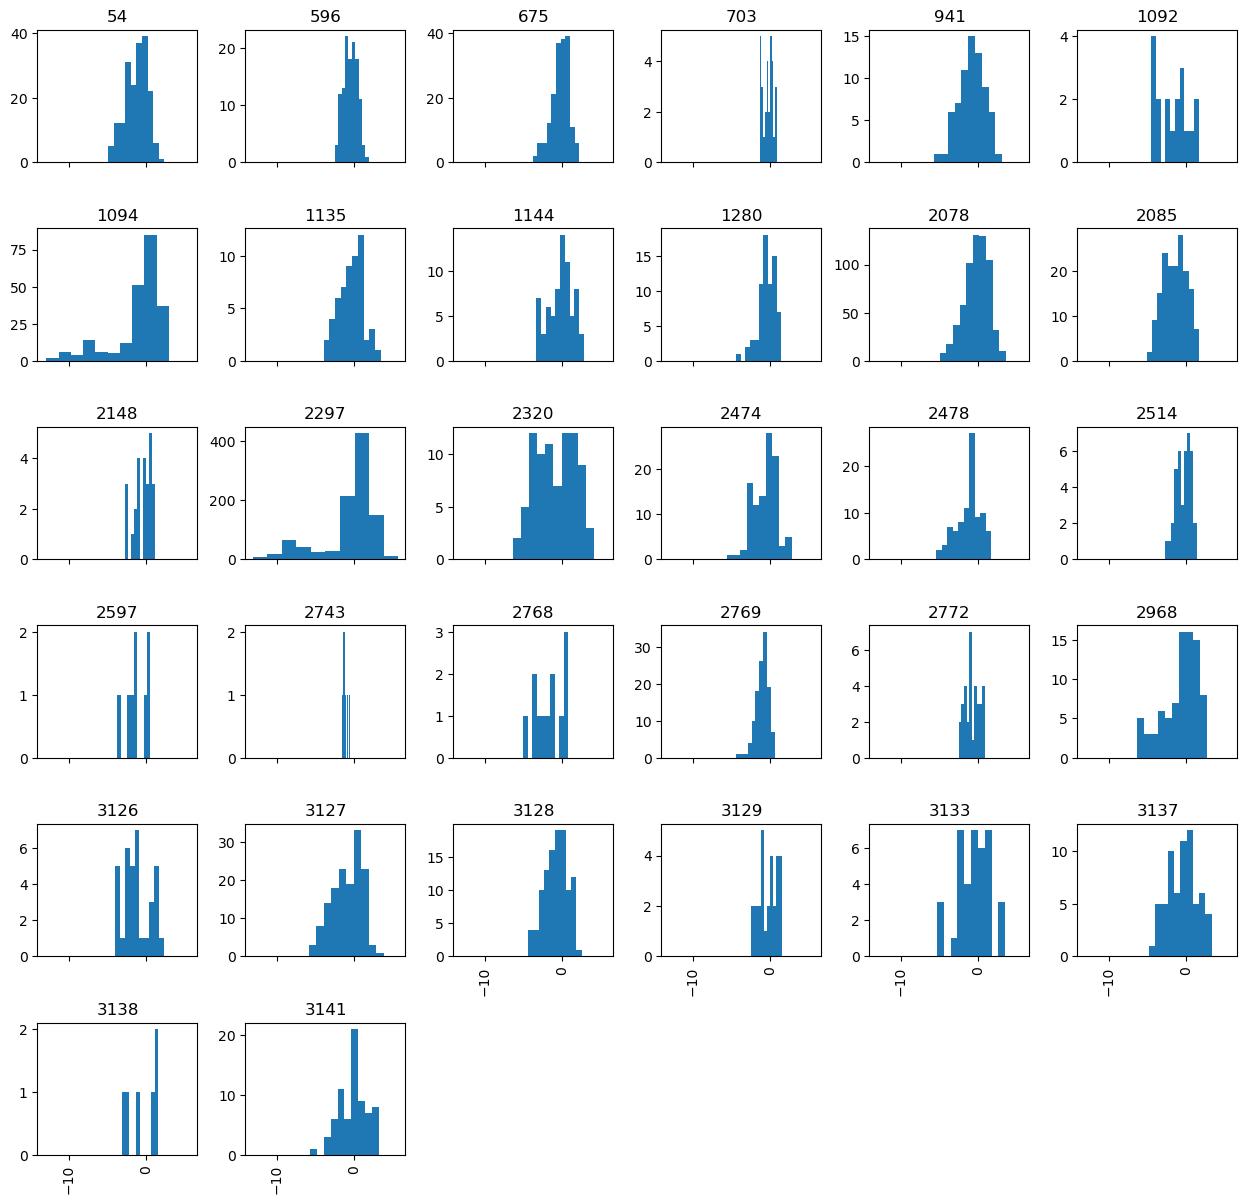

In [13]:
# Plot mass balance values per glacier
data['balance_netto'].hist(by=data['BREID'], figsize=(15,15), sharex=True, grid=True)
plt.show()

In [14]:
print('Number of measurements of mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.count())
print('Glaciers with mass balance values lower than -5 m w.e.: ', data[(data['balance_netto']<-5.0)].BREID.unique())
print('Number of measurements of mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.count())
print('Glaciers with mass balance values lower than -10 m w.e.: ', data[(data['balance_netto']<-10.0)].BREID.unique())

Number of measurements of mass balance values lower than -5 m w.e.:  196
Glaciers with mass balance values lower than -5 m w.e.:  [ 941 1094 2085 2297 2320 2474 2478 2768 2968 3127 3133 3141]
Number of measurements of mass balance values lower than -10 m w.e.:  24
Glaciers with mass balance values lower than -10 m w.e.:  [1094 2297]


## Mass balance by altitude

In [15]:
#Dictionary of region per glacier ID
mapping = {54 : 'FIN', 596 : 'NAR', 675 : 'NAR', 703 : 'NAR', 941 : 'BLA', 1092 : 'SVA',
           1094 : 'SVA', 1135 : 'SVA', 1144 : 'SVA', 1280 : 'SVA', 2078 : 'ALF',
           2085 : 'ALF', 2148 : 'JOB', 2297 : 'JOB', 2320 : 'JOB', 2474 : 'JOB',
           2478 : 'JOB', 2514 : 'JOB', 2597 : 'JOT', 2968 : 'HAR', 2768 : 'JOT',
           2769 : 'JOT', 2772 : 'JOT', 2743 : 'JOT', 3126 : 'FOL', 
           3127 : 'FOL', 3128 : 'FOL', 3129 : 'FOL', 3133 : 'FOL', 3137 : 'FOL', 
           3138 : 'FOL', 3141 : 'FOL'}

# Map region to glacier ID
data['region'] = data.BREID.map(mapping)


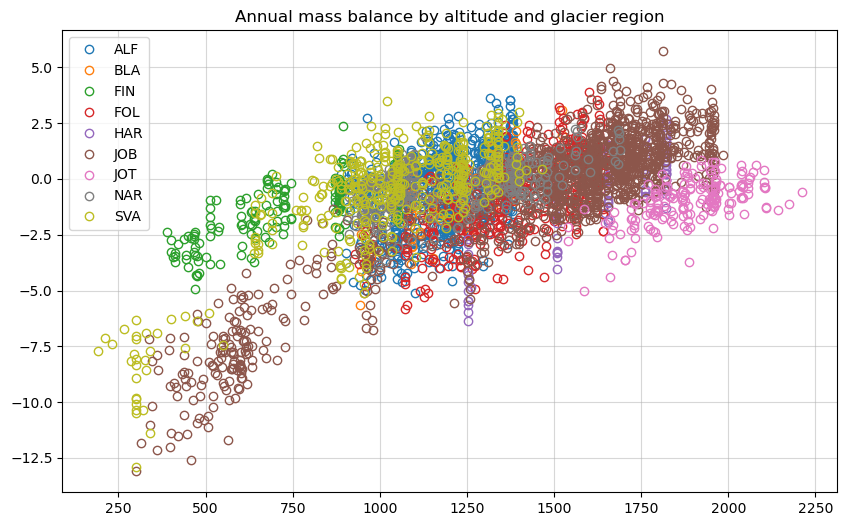

In [16]:
# Group glaciers by region
groups = data.groupby('region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None')
ax.legend()
ax.set_title('Annual mass balance by altitude and glacier region')
plt.grid(alpha=0.5)
plt.show()

In [17]:
#Dictionary of region per glacier ID
mapping_reg = {'FIN' : 'N', 'BLA' : 'N', 'NAR' : 'N', 'SVA' : 'N', 
           'ALF' : 'W-mar', 'FOL' : 'W', 'HAR' : 'W', 'JOB' : 'W', 'JOT' : 'E'}
data['geo_region'] = data.region.map(mapping_reg)


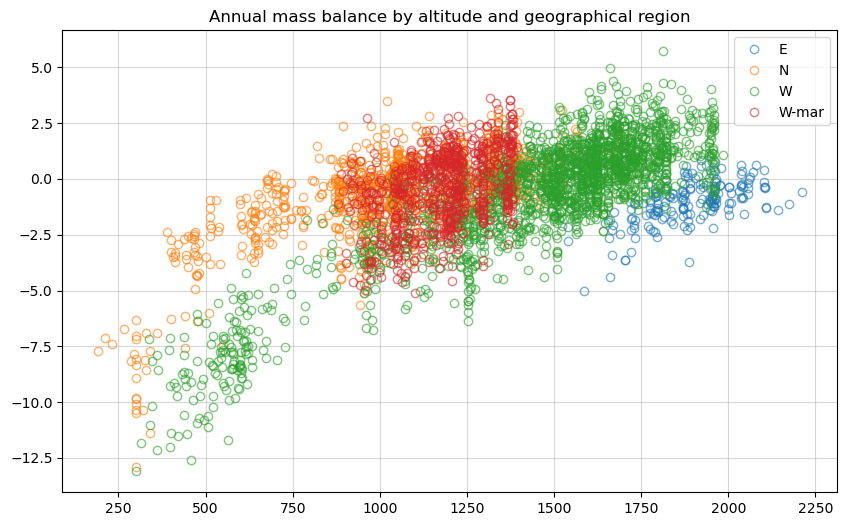

In [18]:
# Group glaciers by broader geographical region
groups = data.groupby('geo_region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.altitude, group.balance_netto, marker='o', linestyle='', ms=6, label=name, mfc='None', alpha=0.6)
ax.legend()
ax.set_title('Annual mass balance by altitude and geographical region')
plt.grid(alpha=0.5)
plt.show()

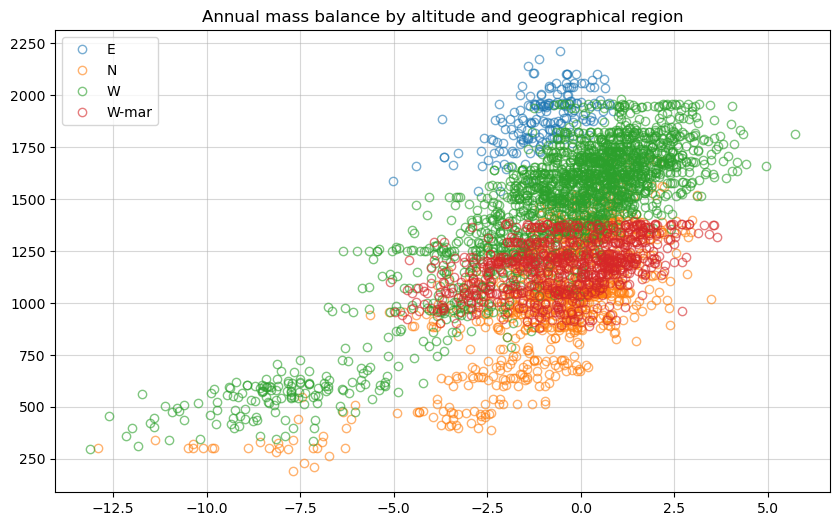

In [19]:
# Group glaciers by broader geographical region
groups = data.groupby('geo_region')

# Plot mass balance as a function of altitude per region
fig, ax = plt.subplots(figsize=(10,6))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.balance_netto, group.altitude, marker='o', linestyle='', ms=6, label=name, mfc='None', alpha=0.6)
ax.legend()
ax.set_title('Annual mass balance by altitude and geographical region')
plt.grid(alpha=0.5)
plt.show()

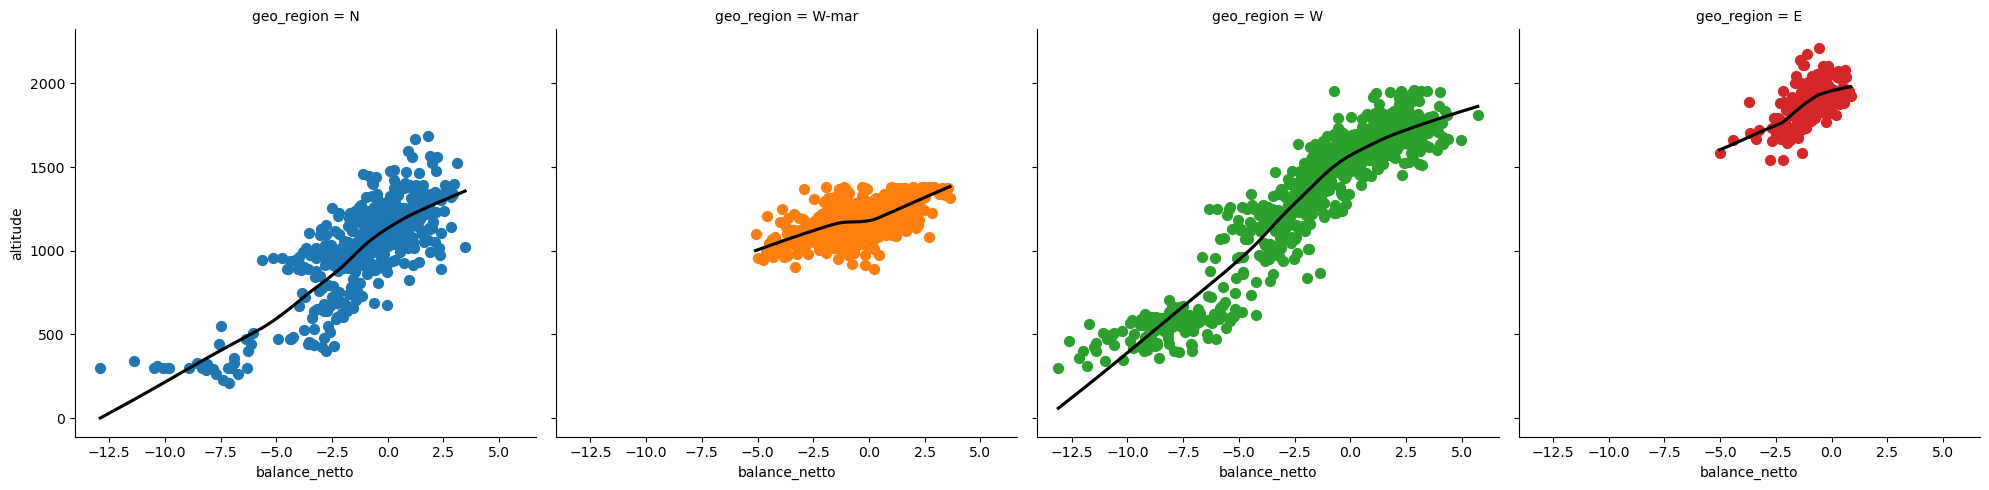

In [20]:
# Lowess
sns.lmplot(data=data, x="balance_netto", y="altitude", hue="geo_region", col='geo_region', lowess=True, ci=None, line_kws={'color': 'k'},
          x_estimator=np.median)


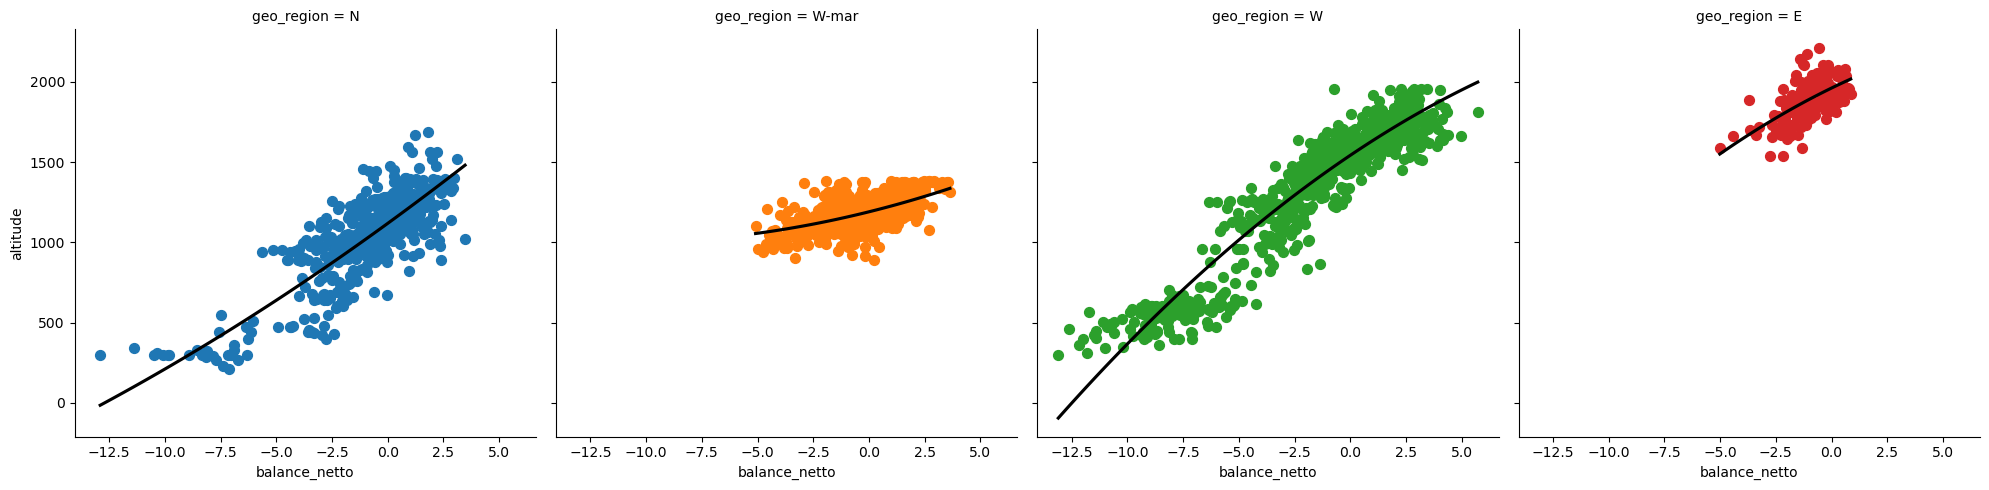

In [21]:
# 2nd order polynomial:
sns.lmplot(data=data, x="balance_netto", y="altitude", hue="geo_region", col='geo_region', order=2, ci=None, line_kws={'color': 'k'},
          x_estimator=np.mean)


## Mass balance distribution plots

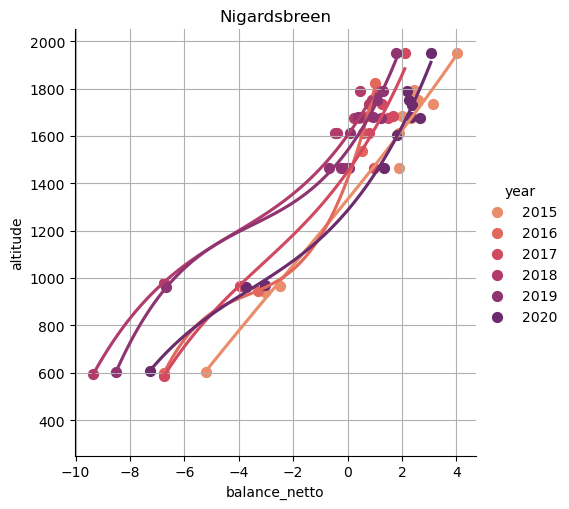

In [27]:
# NIGARDSBREEN MB GRADIENT

data_nig = data[data['BREID']==2297]
#list_yrs = [1962, 1963, 1964, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
#            2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019, 2020]
data_nig_2000 = data_nig[(data_nig['year']>2014) & (data_nig['year']<2022)] # 2014 to 2021
#data_nig_2000 = data_nig[data_nig['year'].isin(list_yrs)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_nig_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean, fit_reg=True)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
s.set(ylim=(250, 2050))
#s.set(xlim=(-12, None))
plt.title('Nigardsbreen')
plt.show()

# Nigardsbreen altitude range 1952 m a.s.l. down to 330 m a.s.l. (from NVE "Glaciological investigations in Norway 2018). 


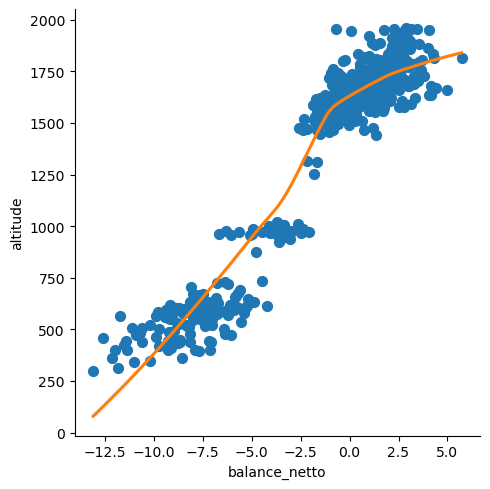

In [28]:
s=sns.lmplot(x='balance_netto', y='altitude', data=data_nig, ci=None, palette='flare', truncate=True,
            x_estimator=np.mean, lowess=True, line_kws={"color": "C1"})


#sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean);


In [29]:
data_nig[(data_nig['year']>2014) & (data_nig['year']<2022)].altitude.max()


1950.0

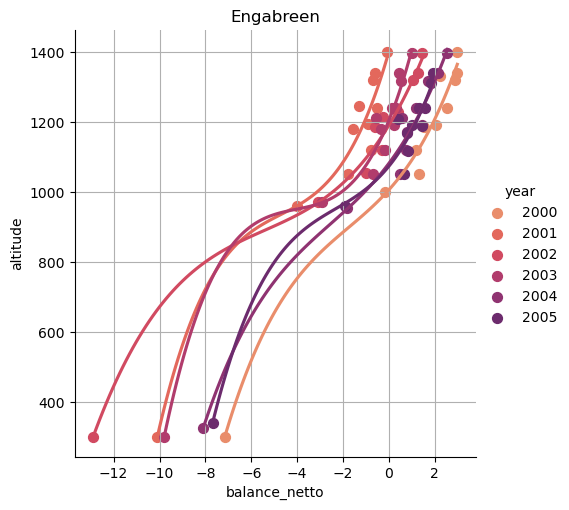

In [30]:
# ENGABREEN MB-GRADIENT

data_eng= data[data['BREID']==1094]
data_eng_2000 = data_eng[(data_eng['year']>1999) & (data_eng['year']<2006)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_eng_2000, hue='year', ci=None, order=3, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Engabreen')
plt.show()

# Engabreen altitude range 111-1544 masl. (from NVE "Glaciological investigations in Norway 2018). 

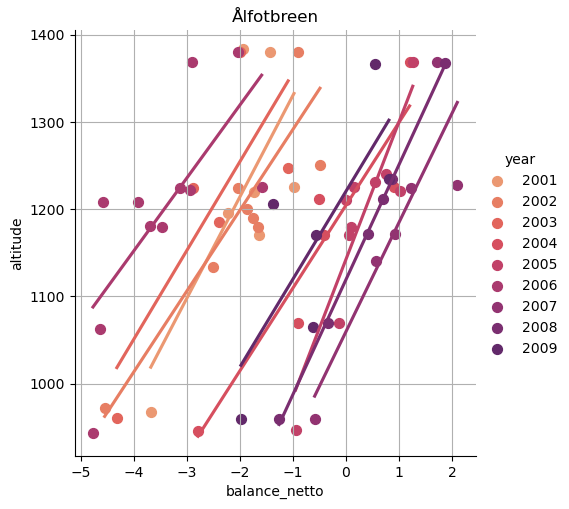

In [31]:
# ÅLFOTBREEN MB GRADIENT

data_alf= data[data['BREID']==2078]
data_alf_2000 = data_alf[(data_alf['year']>2000) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=1, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Ålfotbreen')
plt.show()

# Ålfotbreen altitude range 890-1368 masl. (from NVE "Glaciological investigations in Norway 2018). 

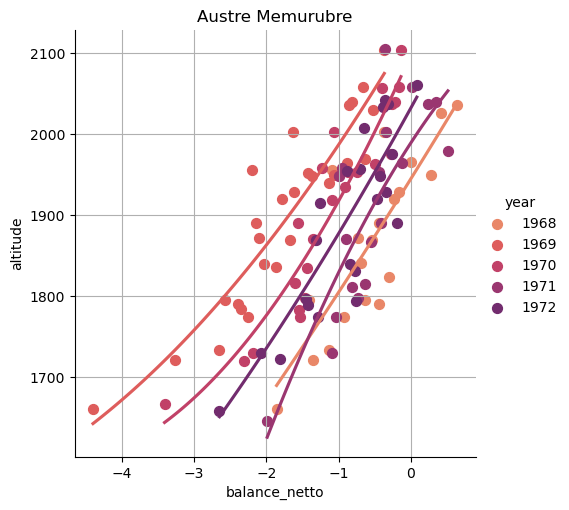

In [32]:
# AUSTRE MEMURUBRE MB GRADIENT

data_alf= data[data['BREID']==2769]
data_alf_2000 = data_alf[(data_alf['year']>1960) & (data_alf['year']<2010)]

s=sns.lmplot(x='balance_netto', y='altitude', data=data_alf_2000, hue='year', ci=None, order=2, palette='flare', truncate=True,
            x_estimator=np.mean)
#s.fig.set_size_inches(9,6)
plt.grid()
#plt.axes('equal')
#s.set(ylim=(500, 2000))
#s.set(xlim=(-12, None))
plt.title('Austre Memurubre')
plt.show()

# Austre Memurubre altitude range XXXX-XXXX masl.  

In [9]:
#for i, group in data_nig.groupby('year'):
#    sns.lmplot(x="balance_netto", y="altitude", data=group, fit_reg=False)
#plt.show()

In [132]:
# Group point measurements by year
#groups = data_nig.groupby('year')

# Plot mass balance as a function of altitude per year
#fig, ax = plt.subplots(figsize=(10,6))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#for year, group in groups:
#    ax.plot(group.balance_netto, group.altitude, marker='o', linestyle='', ms=6, label=year, mfc='None', alpha=0.6)
#ax.legend()
#ax.set_title('Annual mass balance by altitude and geographical region')
#plt.grid(alpha=0.5)
#plt.show()

## Auto-correlation

Autocorrelation is just the correlation of the data with itself. Instead of measuring the correlation between two random variables, 
we are measuring the correlation between a random variable against itself.

In [33]:
data_nig = data[data['BREID']==2297]

In [34]:
data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())
data_nig = data_nig.sort_values(['count','location_id'], ascending=[False, True]).drop('count', axis=1)

# List of 10 stakes locations with longest series
#10 stake locations with length (years): 58, 55, 49, 45, 42, 41, 38, 37, 36, 35
stake_list = data_nig.location_id.unique()[0:10]


C:\Users\kasj\AppData\Local\Temp\ipykernel_2720\991708362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nig['count'] = data_nig['location_id'].map(data_nig['location_id'].value_counts())


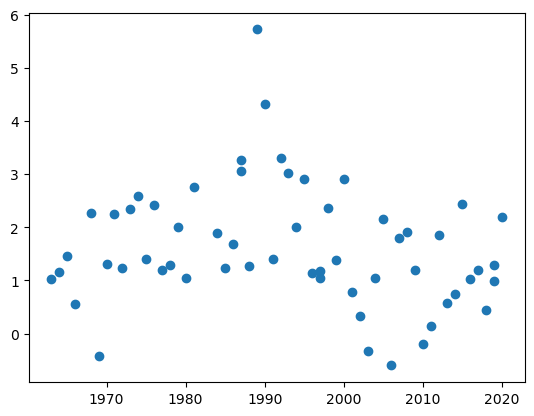

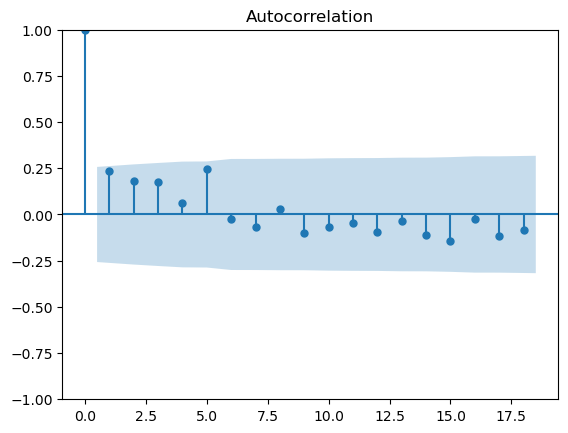

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


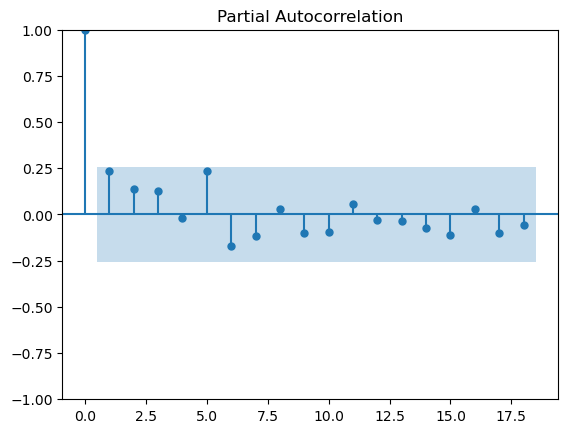

In [35]:
data_stake = data_nig[data_nig.location_id == stake_list[0]]
#data_stake = data_nig[data_nig.location_id == 'N56']
#data_nig = data_nig.sort_values(by=['year'])

plt.plot(data_stake['year'], data_stake['balance_netto'], marker = 'o', linestyle='')
plt.show()

# Use the Autocorrelation function from the statsmodel library passing our DataFrame object in as the data
plot_acf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

plot_pacf(x=np.flip(data_stake['balance_netto'].values))
plt.show()

In [36]:
# Some stake locations contain more than one stake measurements:
data_stake.loc[(data_stake['year']==1995), ['stake_no','altitude','utm_east','utm_north','balance_netto','dt_curr_year_min_date','dt_curr_year_max_date']]

,stake_no,altitude,utm_east,utm_north,balance_netto,dt_curr_year_min_date,dt_curr_year_max_date
2490,N56,1801.0,398068.0,6841212.0,2.91,30.09.1995 00:00,23.04.1995 00:00


# Variograms

The variogram relates the separating distance between two observation points to a measure of observation similarity at that given distance (https://scikit-gstat.readthedocs.io/en/latest/userguide/variogram.html).

The nugget is the y-intercept of the variogram. In practical terms, the nugget represents the small-scale variability of the data. A portion of that short range variability can be the result of measurement error. The range is the distance after which the variogram levels off. The physical meaning of the range is that pairs of points that are this distance or greater apart are not spatially correlated. The sill is the total variance contribution, or the maximum variability between pairs of points. (https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.)

If variance is increasing with distance, points that are distant to each other are less related.

See: https://www.aspexit.com/variogram-and-spatial-autocorrelation/

- For instance, for the exponential model, the range is defined as the distance at which the semi-variance reaches 95% of the sill.

 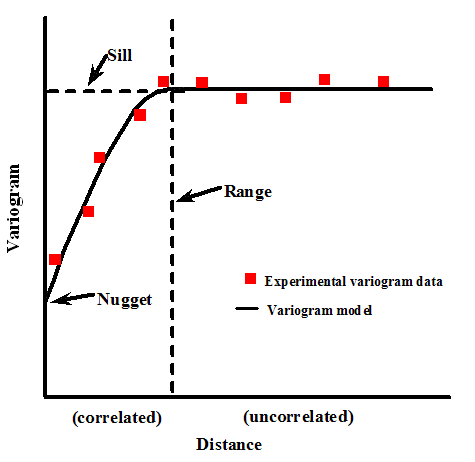
Source: https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.


## Variogram for Nigardsbreen

In [9]:
data_nig = data[data['BREID']==2297]


In [10]:
plt.style.use('ggplot')
x = data_nig['lon'].values
y = data_nig['lat'].values
mb = data_nig['balance_netto'].values

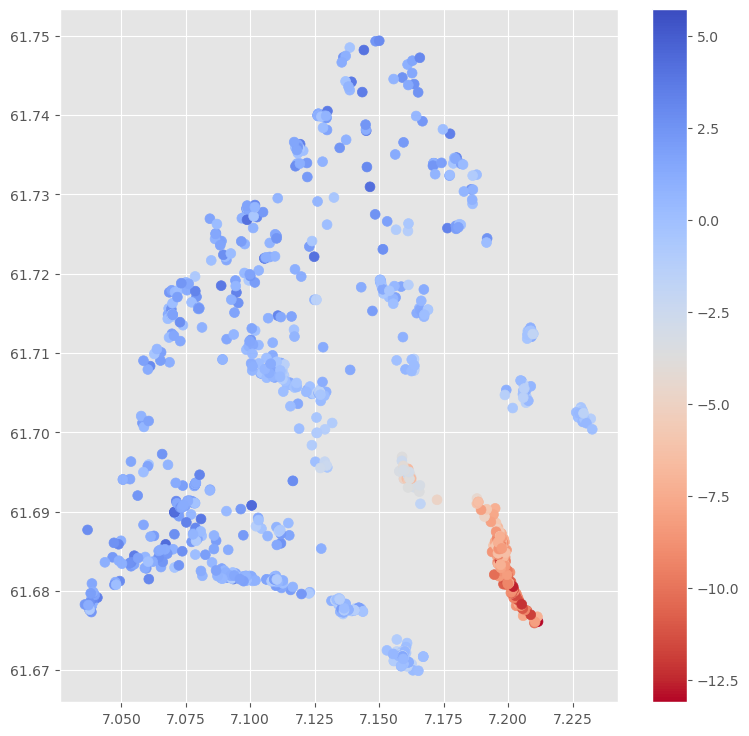

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(x, y, s=50, c=mb.flatten(), cmap='coolwarm_r')
plt.colorbar(art)

In [12]:
coords = np.stack((x,y), axis=1)

In [13]:
coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

In [14]:
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

In [15]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb, latlon=True, geo_scale=gs.KM_SCALE)

In [16]:
print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [0.17817956 0.53453869 0.89089781 1.24725694 1.60361607 1.95997519
 2.31633432 2.67269344 3.02905257 3.3854117  3.74177082 4.09812995
 4.45448907 4.8108482  5.16720733 5.52356645 5.87992558 6.2362847
 6.59264383 6.94900296 7.30536208 7.66172121]
gamma:  [ 1.42615196  1.66639674  1.82598933  1.66908237  2.03087045  2.21696334
  3.89026082  4.69253133  3.95858249  4.30337086  6.22252935  6.0167934
  8.28936306  8.18007451  7.01797375  7.6476796   9.22417964 10.3252115
 10.38434667  9.48386555  8.6368231   8.96252837]
estimated bin number: 22
maximal bin distance: 7.6617212082317


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


JBessel(dim=2, var=5.81, len_scale=1.82, nugget=1.24, nu=6.1e-13)


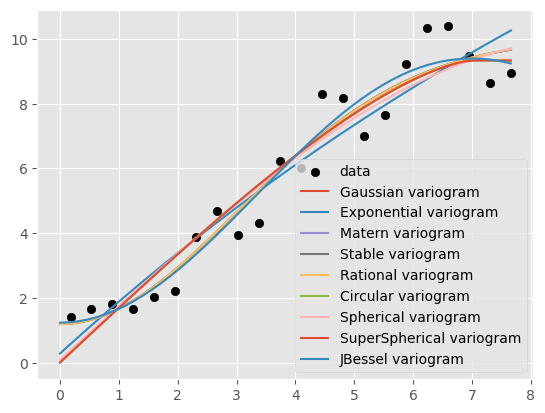

In [17]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

In [18]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.         JBessel: 0.95154
     2.        Gaussian: 0.94479
     3.          Stable: 0.94479
     4.          Matern: 0.94479
     5.        Rational: 0.94455
     6.        Circular: 0.93148
     7.  SuperSpherical: 0.93148
     8.       Spherical: 0.92505
     9.     Exponential: 0.91646


## Variogram using four glaciers of JOB (Nigardsbreen, Austdalsbreen, Vesledalsbreen, Tunsbergdalsbreen)


In [21]:
# Variogram using four glaciers of JOB (Nigardsbreen, Austdalsbreen, Vesledalsbreen, Tunsbergdalsbreen)
data_job = data[data['BREID'].isin([2297, 2474, 2320, 2478])]

x = data_job['lon'].values
y = data_job['lat'].values
mb = data_job['balance_netto'].values
coords = np.stack((x,y), axis=1)

# Use only data that is not nan
coords=coords[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

In [23]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((x, y), mb, latlon=True, geo_scale=gs.KM_SCALE)

print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [ 0.43626309  1.30878928  2.18131547  3.05384166  3.92636785  4.79889404
  5.67142023  6.54394642  7.41647261  8.2889988   9.16152499 10.03405118
 10.90657737 11.77910356 12.65162975 13.52415594 14.39668213 15.26920832
 16.14173451 17.0142607  17.88678689 18.75931308]
gamma:  [ 1.56873909  1.79633856  3.43979264  4.15645707  6.00045087  8.0218296
  8.00103674  9.96294347  8.58742692  8.09319922 11.00821536 17.21906935
 16.78995484 18.21290846 18.37764408 18.62654846 20.08760497 16.83741924
 13.19486775 12.58421538 20.80223705 18.48515438]
estimated bin number: 22
maximal bin distance: 18.759313075525423


JBessel(dim=2, var=15.7, len_scale=2.44, nugget=1.99, nu=1.92)


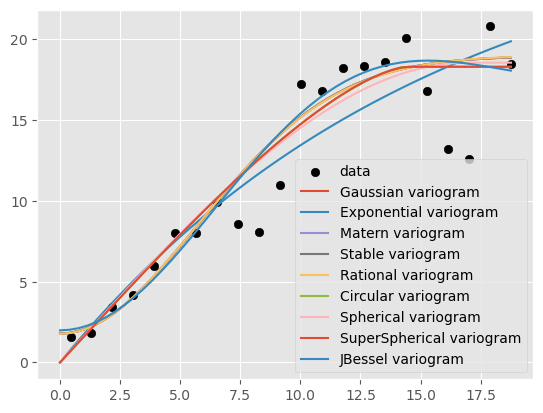

In [24]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

In [25]:
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

RANKING by Pseudo-r2 score
     1.        Circular: 0.85569
     2.  SuperSpherical: 0.85569
     3.         JBessel: 0.85051
     4.       Spherical: 0.845
     5.          Matern: 0.84448
     6.          Stable: 0.84448
     7.        Gaussian: 0.84448
     8.        Rational: 0.84414
     9.     Exponential: 0.82694


Spherical and exponential are most widely used.

SuperSpherical(dim=2, var=18.3, len_scale=14.4, nugget=2.01e-11, nu=0.5)


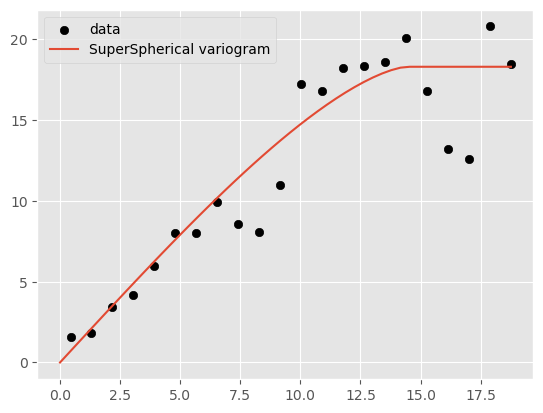

In [26]:
# SuperSpherical, Circular variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
fit_model = gs.SuperSpherical(dim=2)
para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
fit_model.plot(x_max=max(bin_center), ax=ax)

print(fit_model)

Nugget (y-intercept): The nugget is the y-intercept of the variogram. In practical terms, the nugget represents the small-scale variability of the data. A portion of that short range variability can be the result of measurement error. 
(https://vsp.pnnl.gov/help/Vsample/Kriging_Variogram_Model.htm#:~:text=The%20nugget%20is%20the%20y,which%20the%20variogram%20levels%20off.)

Spherical(dim=2, var=18.6, len_scale=16.9, nugget=3.74e-17)


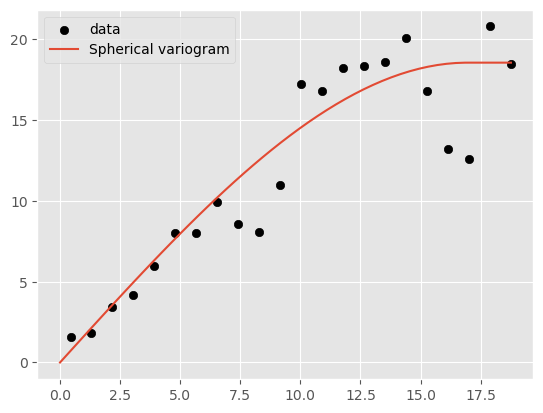

In [29]:
# Circular variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
fit_model = gs.Spherical(dim=2)
para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
fit_model.plot(x_max=max(bin_center), ax=ax)

print(fit_model)

## 3D Directional variogram using lat, lon, altitude for Jostedalsbreen glaciers
https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/03_variogram/04_directional_3d.html

In [89]:
# Variogram using four glaciers of JOB (Nigardsbreen, Austdalsbreen, Vesledalsbreen, Tunsbergdalsbreen)
data_job = data[data['BREID'].isin([2297, 2478, 2320, 2474])]

data_job = data_job[data_job['year']==2010]

In [91]:
x = data_job['lon'].values
y = data_job['lat'].values
z = data_job['altitude'].values
mb = data_job['balance_netto'].values
#coords = np.stack((x,y), axis=1)

# Use only data that is not nan
#coords=coords[~np.isnan(mb)]
x = x[~np.isnan(mb)]
y = y[~np.isnan(mb)]
z = z[~np.isnan(mb)]
mb_clean=mb[~np.isnan(mb)]

pos = (x,y,z)

#mb_clean has shape (1262,)
# pos has shape ((1262,),(1262,),(1262,0)


In [104]:
coords = np.stack((x,y,z),axis=1)

In [106]:
coords.shape

(17, 3)

In [63]:
#dim = 3
# rotation around z, y, x
#angles = [np.deg2rad(90), np.deg2rad(45), np.deg2rad(22.5)]
#model = gs.Gaussian(dim=3, len_scale=[16, 8, 4], angles=angles)
#x = y = z = range(50)
#pos = (x, y, z)
#srf = gs.SRF(model, seed=1001)
#field = srf.structured(pos)

In [111]:
coords.shape

(17, 3)

In [107]:
dim = 3
angles = [np.deg2rad(90), np.deg2rad(90), np.deg2rad(90)]
main_axes = gs.rotated_main_axes(dim, angles)
axis1, axis2, axis3 = main_axes

In [109]:
bin_center, dir_vario, counts = gs.vario_estimate(
    coords,
    mb_clean,
    direction=main_axes,
    bandwidth=10,
    sampling_size=2000,
    sampling_seed=1001,
    mesh_type="unstructured",
    return_counts=True,
)

ValueError: Formatting: position tuple doesn't match dimension.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(121, projection=Axes3D.name)
ax2 = fig.add_subplot(122)

ax1.plot([0, axis1[0]], [0, axis1[1]], [0, axis1[2]], label="0.")
ax1.plot([0, axis2[0]], [0, axis2[1]], [0, axis2[2]], label="1.")
ax1.plot([0, axis3[0]], [0, axis3[1]], [0, axis3[2]], label="2.")
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Tait-Bryan main axis")
ax1.legend(loc="lower left")

x_max = max(bin_center)
ax2.scatter(bin_center, dir_vario[0], label="0. axis")
ax2.scatter(bin_center, dir_vario[1], label="1. axis")
ax2.scatter(bin_center, dir_vario[2], label="2. axis")
model.plot("vario_axis", axis=0, ax=ax2, x_max=x_max, label="fit on axis 0")
model.plot("vario_axis", axis=1, ax=ax2, x_max=x_max, label="fit on axis 1")
model.plot("vario_axis", axis=2, ax=ax2, x_max=x_max, label="fit on axis 2")
ax2.set_title("Fitting an anisotropic model")
ax2.legend()

plt.show()

### TO-DO Automatic binning with lat-lon data:
https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/03_variogram/06_auto_bin_latlon.html


### Spatio-temporal lat/lon fields:
https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/09_spatio_temporal/03_geographic_coordinates.html

In [57]:
#emp_v = gs.vario_estimate(coords.T, mb_clean.T, latlon=True, geo_scale=gs.KM_SCALE)
#sph = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
#sph.fit_variogram(*emp_v, sill=np.var(mb_clean.T))
#ax = sph.plot("vario_yadrenko", x_max=2 * np.max(emp_v[0]))
#ax.scatter(*emp_v, label="Empirical variogram")
#ax.legend()
#print(sph)

In [60]:
# Using gstools

#V = skg.Variogram(coords, mb_clean.flatten(), maxlag='median', n_lags=15, normalize=False)
#fig = V.plot(show=False)
#print(V.describe())

In [16]:
# Two glaciers

#list = [2297, 2478]
#data_nig_aus = data[data['BREID'].isin(list)]
#x = data_nig_aus['lon'].values
#y = data_nig_aus['lat'].values
#mb = data_nig_aus['balance_netto'].values
#coords = np.stack((x,y), axis=1)
#coords=coords[~np.isnan(mb)]
#mb_clean=mb[~np.isnan(mb)]

## Correlation plots

<Axes: >

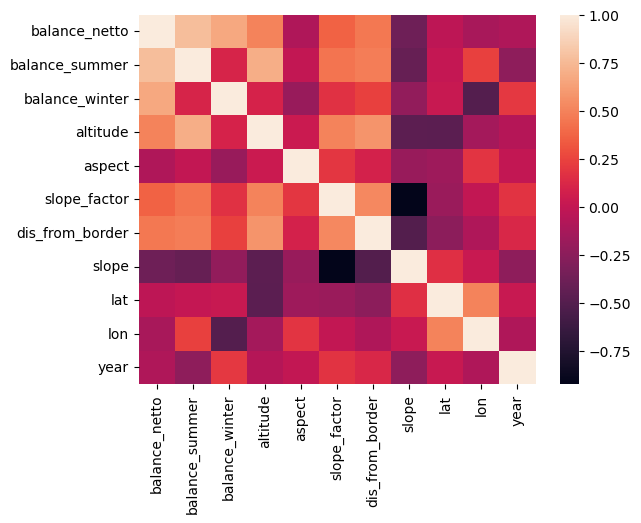

In [24]:
#Plot correlations topo
columns=['balance_netto','balance_summer','balance_winter','altitude','aspect',
         'slope_factor', 'dis_from_border','slope','lat','lon','year']

#pearson : standard correlation coefficient
#kendall : Kendall Tau correlation coefficient
#spearman : Spearman rank correlation

corr = data[columns].corr(method='spearman')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Negative correlation between annual/summer balance and slope (higher slope = more positive mb?).
Negative correlation between altitude and slope (higher altitude = lower slope)

Lower elevations have steeper slopes - Nigardsbreen?

Slope correlates with slope factor, remove slope factor from features.

In [58]:
#list_cols = list(data.columns)#.to_list#[[-168,:]]
#columns = ['balance_netto']
#columns.extend(list_cols[-169:])
#corr = data[columns].corr(method='spearman')

# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year','region','geo_region']

topo = ['altitude', 'slope', 'aspect', 'altitude_climate','slope_factor','lat','lon']
snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surf_press = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, topo, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, dewpt_temp, surf_press, snowfall, snow_albedo] for y in x]

#Select features
data_selected = data.drop(drop_cols, axis=1)
corr = data_selected.corr(method='spearman')

In [67]:
data_selected.shape

(3910, 133)

In [59]:
#list(data_selected.columns)

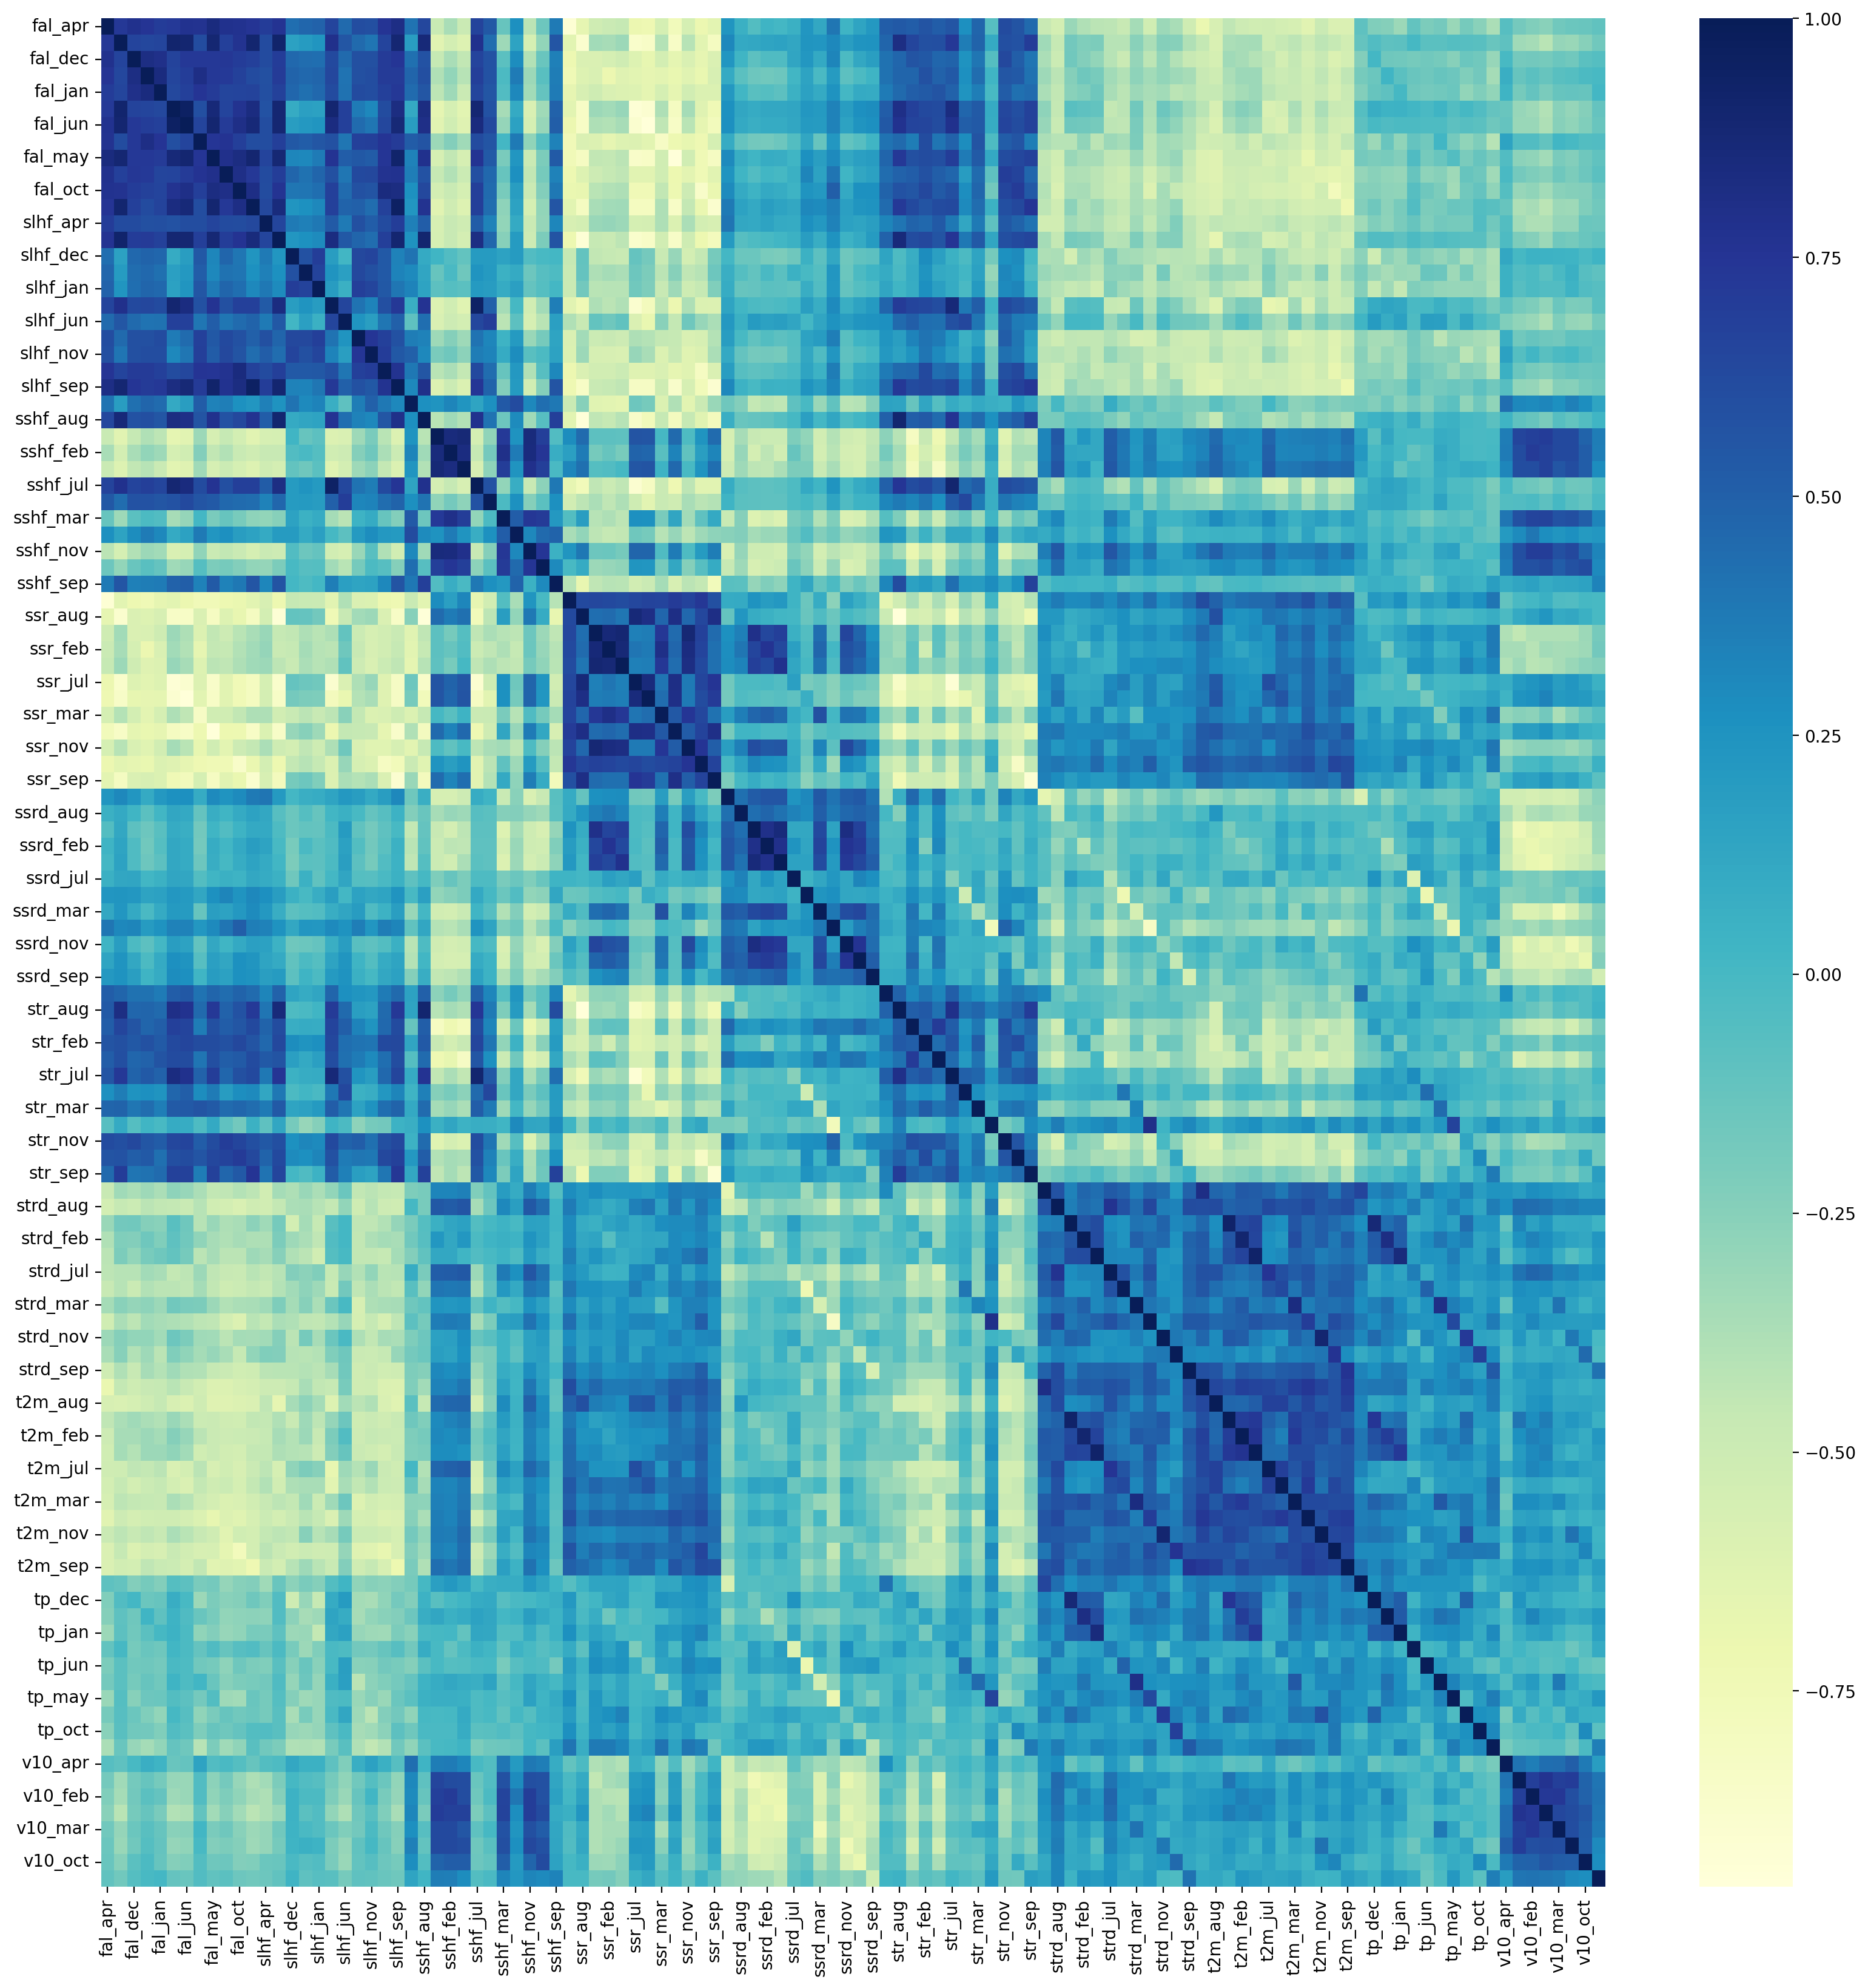

In [55]:
from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations

def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

#labels = [chr(x) for x in range(65,91)]
#corrDf = DataFrame(randn(26,26), index=labels, columns=labels).corr()

#heatmap(corrDf,cmap="YlGnBu")
fig, ax = plt.subplots(1,1,figsize=(20,20), dpi=200)
heatmap(absHighPass(corr,0.5),cmap="YlGnBu", ax=ax)
show()

In [68]:
# pearson's correlation feature selection for numeric input and numeric output
# Select features for training
#df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
#df_train_y_s = df_train_s[['balance_netto']]

# Remove cells with nan in balance_netto.
data_selected = data_selected[data_selected['balance_netto'].notna()]
data_selected.reset_index(drop=True, inplace=True)

X, y = data_selected.drop(['balance_netto'], axis=1).values, data_selected['balance_netto'].values

from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
#X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
# define feature selection

# 132 climate features, reduce to 100
fs = SelectKBest(score_func=f_regression, k=100)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(3910, 100)


In [69]:
cols_idxs = fs.get_support(indices=True)
features_df_new = data_selected.iloc[:,cols_idxs]

In [71]:
list(features_df_new.columns)

['u10_nov',
 'u10_dec',
 'u10_jan',
 'u10_feb',
 'u10_jun',
 'u10_jul',
 'u10_aug',
 'v10_oct',
 'v10_nov',
 'v10_jan',
 'v10_feb',
 'v10_mar',
 'v10_jun',
 'v10_jul',
 'v10_sep',
 't2m_oct',
 't2m_nov',
 't2m_dec',
 't2m_jan',
 't2m_feb',
 't2m_apr',
 't2m_may',
 't2m_jun',
 't2m_jul',
 't2m_aug',
 't2m_sep',
 'fal_oct',
 'fal_nov',
 'fal_dec',
 'fal_jan',
 'fal_feb',
 'fal_mar',
 'fal_apr',
 'fal_may',
 'fal_jun',
 'fal_jul',
 'fal_aug',
 'slhf_nov',
 'slhf_feb',
 'slhf_apr',
 'slhf_may',
 'slhf_jun',
 'slhf_jul',
 'slhf_aug',
 'slhf_sep',
 'ssr_oct',
 'ssr_nov',
 'ssr_dec',
 'ssr_jan',
 'ssr_feb',
 'ssr_mar',
 'ssr_apr',
 'ssr_may',
 'ssr_jun',
 'ssr_jul',
 'ssr_aug',
 'ssr_sep',
 'str_oct',
 'str_nov',
 'str_jan',
 'str_feb',
 'str_mar',
 'str_apr',
 'str_may',
 'str_jun',
 'str_jul',
 'str_aug',
 'str_sep',
 'sshf_oct',
 'sshf_nov',
 'sshf_dec',
 'sshf_jan',
 'sshf_feb',
 'sshf_may',
 'sshf_jun',
 'sshf_jul',
 'sshf_aug',
 'ssrd_jan',
 'ssrd_feb',
 'ssrd_mar',
 'ssrd_jul',
 'ssrd_